# Introduction
This notebook is for testing the validity of our algorithm to model an semi-flexible rod-pin filaments.

Filaments are composed of inextensible rods (spherocylinders with length-width aspect ratios larger than 2) attached in series by a pinning constraint, i.e., the minus-end of the next rod is constrained to be at the position of the plus-end of the previous.

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import gc
import pickle as pkl

# Data manipulation
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf, erfinv, erfi
from scipy.integrate import quad
from scipy.signal import savgol_filter, correlate, fftconvolve
from scipy.sparse import csr_matrix, dia_matrix, csc_matrix, coo_matrix
from scipy import fftpack
import torch
from functools import reduce
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'torch device: {device}')

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
import matplotlib.pylab as plb

# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps
import alens_analysis.helpers as ahlp
import alens_analysis.read_func as arf
from alens_analysis import physical_scales as ps

# Graph style settings
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)
# silence warnings
import warnings
warnings.filterwarnings("ignore")
kBT = .00411

torch device: cuda


In [2]:
data_dir = Path.home() / "projects/DATA/Testing/"
data_dir_list = [
    data_dir / "SemiFlexRodDimer",
]
for i in data_dir_list:
    assert i.exists(), f"{i} does not exist"


I will leave the spring stiffness at $k=3650$ pN/$\mu\text{m}$ though we should see how changing this affects the results.

### Run parameters
```yaml
viscosity : 1 # pN s/um^2
dt : 0.00001 s 
T_tot : 1 s  
t_snap : 0.001 s 
bendLinkKappa: [.106, .106, .106] # pN/rad
KBT: 0.00411 # controls Brownian motion of MT
```


### Relaxation time calculations
Based off this [paper](https://arxiv.org/abs/1410.0139). Note that the potential they base calculations differ in that their Hamiltonian
$$ H = \lambda \sum_{n=1}^N (|\bm{r}_n| - d)^2 - 2\kappa \sum_{n=1}^{N-1} \bm{r}_n \cdot \bm{r}_{n+1} $$
where $\bm{r}_n$ is the separation vector between the $n$-th and $(n-1)$-th bead, $\lambda$ is the extendable spring constant, $d$ is the bead diameter, and $\kappa$ is the bending stiffness. The potential we solve in our equations is
$$ H = \lambda \sum_{n=1}^N (|\bm{r}_n| - d)^2 - 2\kappa \sum_{n=1}^{N-1} \frac{\bm{r}_n \cdot \bm{r}_{n+1}}{r_n r_{n+1}} $$
where $r_n$ is the distance between the $n$-th and $(n-1)$-th. To make the conversion between the two, I need to multiply there bending constant by the bead diameters squared $d^2$ to make the units work out. Still we can use their theory to extract some useful information. For example, the longitudinal and approximate transverse relaxation times of the system are given by
$$ \tau_p^\parallel = \frac{\gamma}{\lambda} \left\{2\left[1-\cos\left(\frac{p\pi}{N+1}\right)\right]\left[1-\frac{2\kappa}{\lambda}\cos\left(\frac{p\pi}{N+1}\right)\right]\right\}^{-1} $$ 
and 
$$ \tau_p^\perp \approx \frac{\gamma}{4\kappa} \left\{\left[1-\cos\left(\frac{p\pi}{N+1}\right)\right]\left[1-\cos\left(\frac{(p-1)\pi}{N+1}\right)\right]\right\}^{-1} $$ 
where drag coefficient $\gamma=3\pi d \eta$ with the viscosity $\eta$ of the surrounding fluid. 

In [3]:
def longitudinal_relax_time(k_bend, k_extend, diam, visc, n_beads, p=1):
    drag = 3 * np.pi * visc * diam
    pre_fact = drag / k_extend
    eigval = 2.*(1. - np.cos(p*np.pi/(n_beads+1))) * (1.-2.*(k_bend/(diam*diam*k_extend))*np.cos(p*np.pi/(n_beads+1)))
    return pre_fact / eigval

def trans_relax_time(k_bend, diam, visc, n_beads, p=1):
    drag = 3 * np.pi * visc * diam
    pre_fact = .25 * drag*diam*diam / (k_bend)
    eigval = (1. - np.cos(p*np.pi/(n_beads+1))) * (1.-np.cos((p-1)*np.pi/(n_beads+1)))
    return pre_fact / eigval

Notice that the longitudinal relaxation time becomes infinitely large when $\lambda = \infty$. This then models a WLC. Four our parameters, we get the values

In [4]:
visc = 1.
k_bend = 1.
diam = .01
k_extend = 100. 
n_beads = 100
print(f"Longitudinal relaxation time: {longitudinal_relax_time(k_bend, k_extend, diam, visc, n_beads)} s ")
print(f"Transverse relaxation time: {trans_relax_time(k_bend, diam, visc, n_beads, p=2)} s")

Longitudinal relaxation time: -0.004897869977849996 s 
Transverse relaxation time: 2.5180956491094246 s


What does it mean to have a negative relaxation time? Will this cause the system to be unstable? Or does the theory just require that $\lambda > 2\kappa$? This shouldn't be the case for our systems but I guess we will find out. Let's look at the maximum and minimum relaxation times for our system.

In [5]:
visc = 1.
diam = .01
n_beads = 50

# Max
k_extend = 10. 
k_bend = .00166
print(f"Max longitudinal relaxation time: {longitudinal_relax_time(k_bend, k_extend, diam, visc, n_beads)} s ")
print(f"Max transverse relaxation time: {trans_relax_time(k_bend, diam, visc, n_beads, p=2)} s")

# Min
k_extend = 100000. 
k_bend = 1.7 
print(f"Min longitudinal relaxation time: {longitudinal_relax_time(k_bend, k_extend, diam, visc, n_beads)} s ")
print(f"Min transverse relaxation time: {trans_relax_time(k_bend, diam, visc, n_beads, p=2)} s")

Max longitudinal relaxation time: -1.0738446265083292 s 
Max transverse relaxation time: 98.73496596918817 s
Min longitudinal relaxation time: 0.0003760806612708856 s 
Min transverse relaxation time: 0.09641179029932491 s


## Long Brownian filament tests

0.06999987
[  1.00011451 177.67995269]


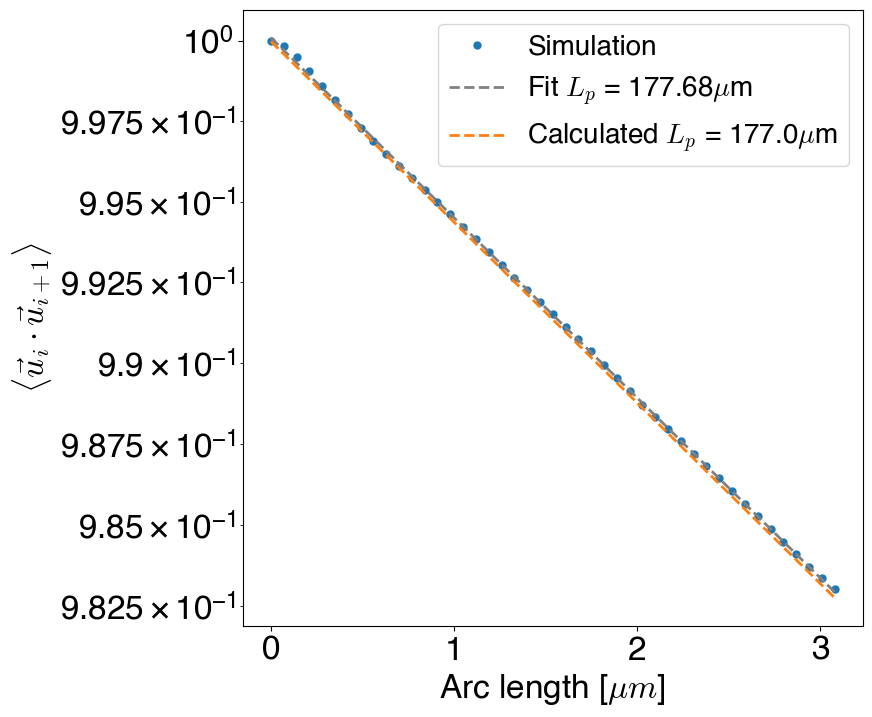

In [8]:
test_dir = Path.home() / 'projects/DATA/my_alens_data/PinRodSemiFlexTests/LongFilaments/PinRodSemiFlexFilament_v2'
fig, axarr = plt.subplots(1,1, figsize=(8, 8))

with h5py.File(next(test_dir.glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][:] 
    # Load in sylinder data
    sy_dat = h5_data['raw_data/sylinders'][...]
    dir_arr = (-sy_dat[:, 2:5,100::10] + sy_dat[:, 5:8, 100::10])
    length = np.linalg.norm(dir_arr[0,:,0])
    print(length)
    dir_arr /= length
    n_segs = dir_arr.shape[0]-10
    dot_mat = np.einsum('ijk,ljk->ilk', dir_arr, dir_arr).mean(axis=2)
    arc_length_arr = np.arange(n_segs)*length
    avg_dot_arr = np.zeros(n_segs)
    avg_dot_arr[0] = 1.
    for i in range(1, n_segs):
        avg_dot_arr[i] = np.diag(dot_mat, i).mean()
    
    # Fit persistence length
    def fit_func(x, a, Lp):
        return a*np.exp(-x/Lp)
    
    popt, pcov = curve_fit(fit_func, arc_length_arr[:], avg_dot_arr[:])
    print(popt)
    kappa_bend = yaml.safe_load(h5_data.attrs['RunConfig'])['bendLinkKappa']
    Lp = kappa_bend*length/kBT

    _ = axarr.plot(arc_length_arr[:], avg_dot_arr[:], marker='o', linestyle='none', markersize=5, label=f'Simulation')
    _ = axarr.plot(arc_length_arr, fit_func(arc_length_arr, *popt), color='gray',  linestyle='--', label='Fit $L_p$ = {:.2f}$\mu$m'.format(popt[1]))
    _ = axarr.plot(arc_length_arr, fit_func(arc_length_arr, 1, Lp), color='tab:orange',  linestyle='--', label=f'Calculated $L_p$ = {Lp:.1f}$\mu$m')
    # _ = axarr.set_ylim(.0001, 2)
    _ = axarr.legend()
    _ = axarr.set_yscale('log')
    _ = axarr.set_xlabel('Arc length [$\mu m$]')
    _ = axarr.set_ylabel('$\langle \\vec{u}_i \\cdot \\vec{u}_{i+1} \\rangle$')

## Long filament slice

In [35]:
test_dir = Path.home() / "projects/DATA/Testing/SemiFlexBeadSpringFilament"
h5_list = list(test_dir.glob('simulations/*/analysis/raw*.h5'))
data_dict = {}
for h5d in h5_list:
    with h5py.File(h5d, 'r') as h5_data:
        run_params = yaml.safe_load(h5_data.attrs['RunConfig'])
        kappa_extend = run_params['extendLinkKappa']
        kappa_bend = run_params['tribendLinkKappa']
        dt = run_params['dt']
        # See if dt value is already in data_dict. If not add it otherwise append to existing list
        if kappa_bend not in data_dict:
            data_dict[kappa_bend] = {}
        if kappa_extend not in data_dict[kappa_bend]:
            data_dict[kappa_bend][kappa_extend] = {}
        data_dict[kappa_bend][kappa_extend][dt]= h5d

k_bend_list = sorted(data_dict.keys())
print("k_bend: ", k_bend_list)
k_extend_list = sorted(data_dict[k_bend_list[0]].keys())
print("k_extend: ", k_extend_list)
dt_list = sorted(data_dict[k_bend_list[0]][k_extend_list[-1]].keys(), reverse=True)
print("dt: ", dt_list)


k_bend:  [0.00166572026, 0.106606097, 1.70569755]
k_extend:  [10.275, 1027.5, 102750.0]
dt:  [0.001, 0.0001, 1e-05, 1e-06]


(100, 3, 1002)
(100, 3, 1002)
(100, 3, 1002)
(100, 3, 1002)
(100, 3, 1002)
(100, 3, 1002)
(100, 3, 1002)
(100, 3, 1002)
(100, 3, 1002)
(100, 3, 1002)
(100, 3, 1002)
(100, 3, 1002)
(100, 3, 1002)
(100, 3, 1002)
(100, 3, 1002)
(100, 3, 1002)
(100, 3, 1002)
(100, 3, 1002)
(100, 3, 1002)


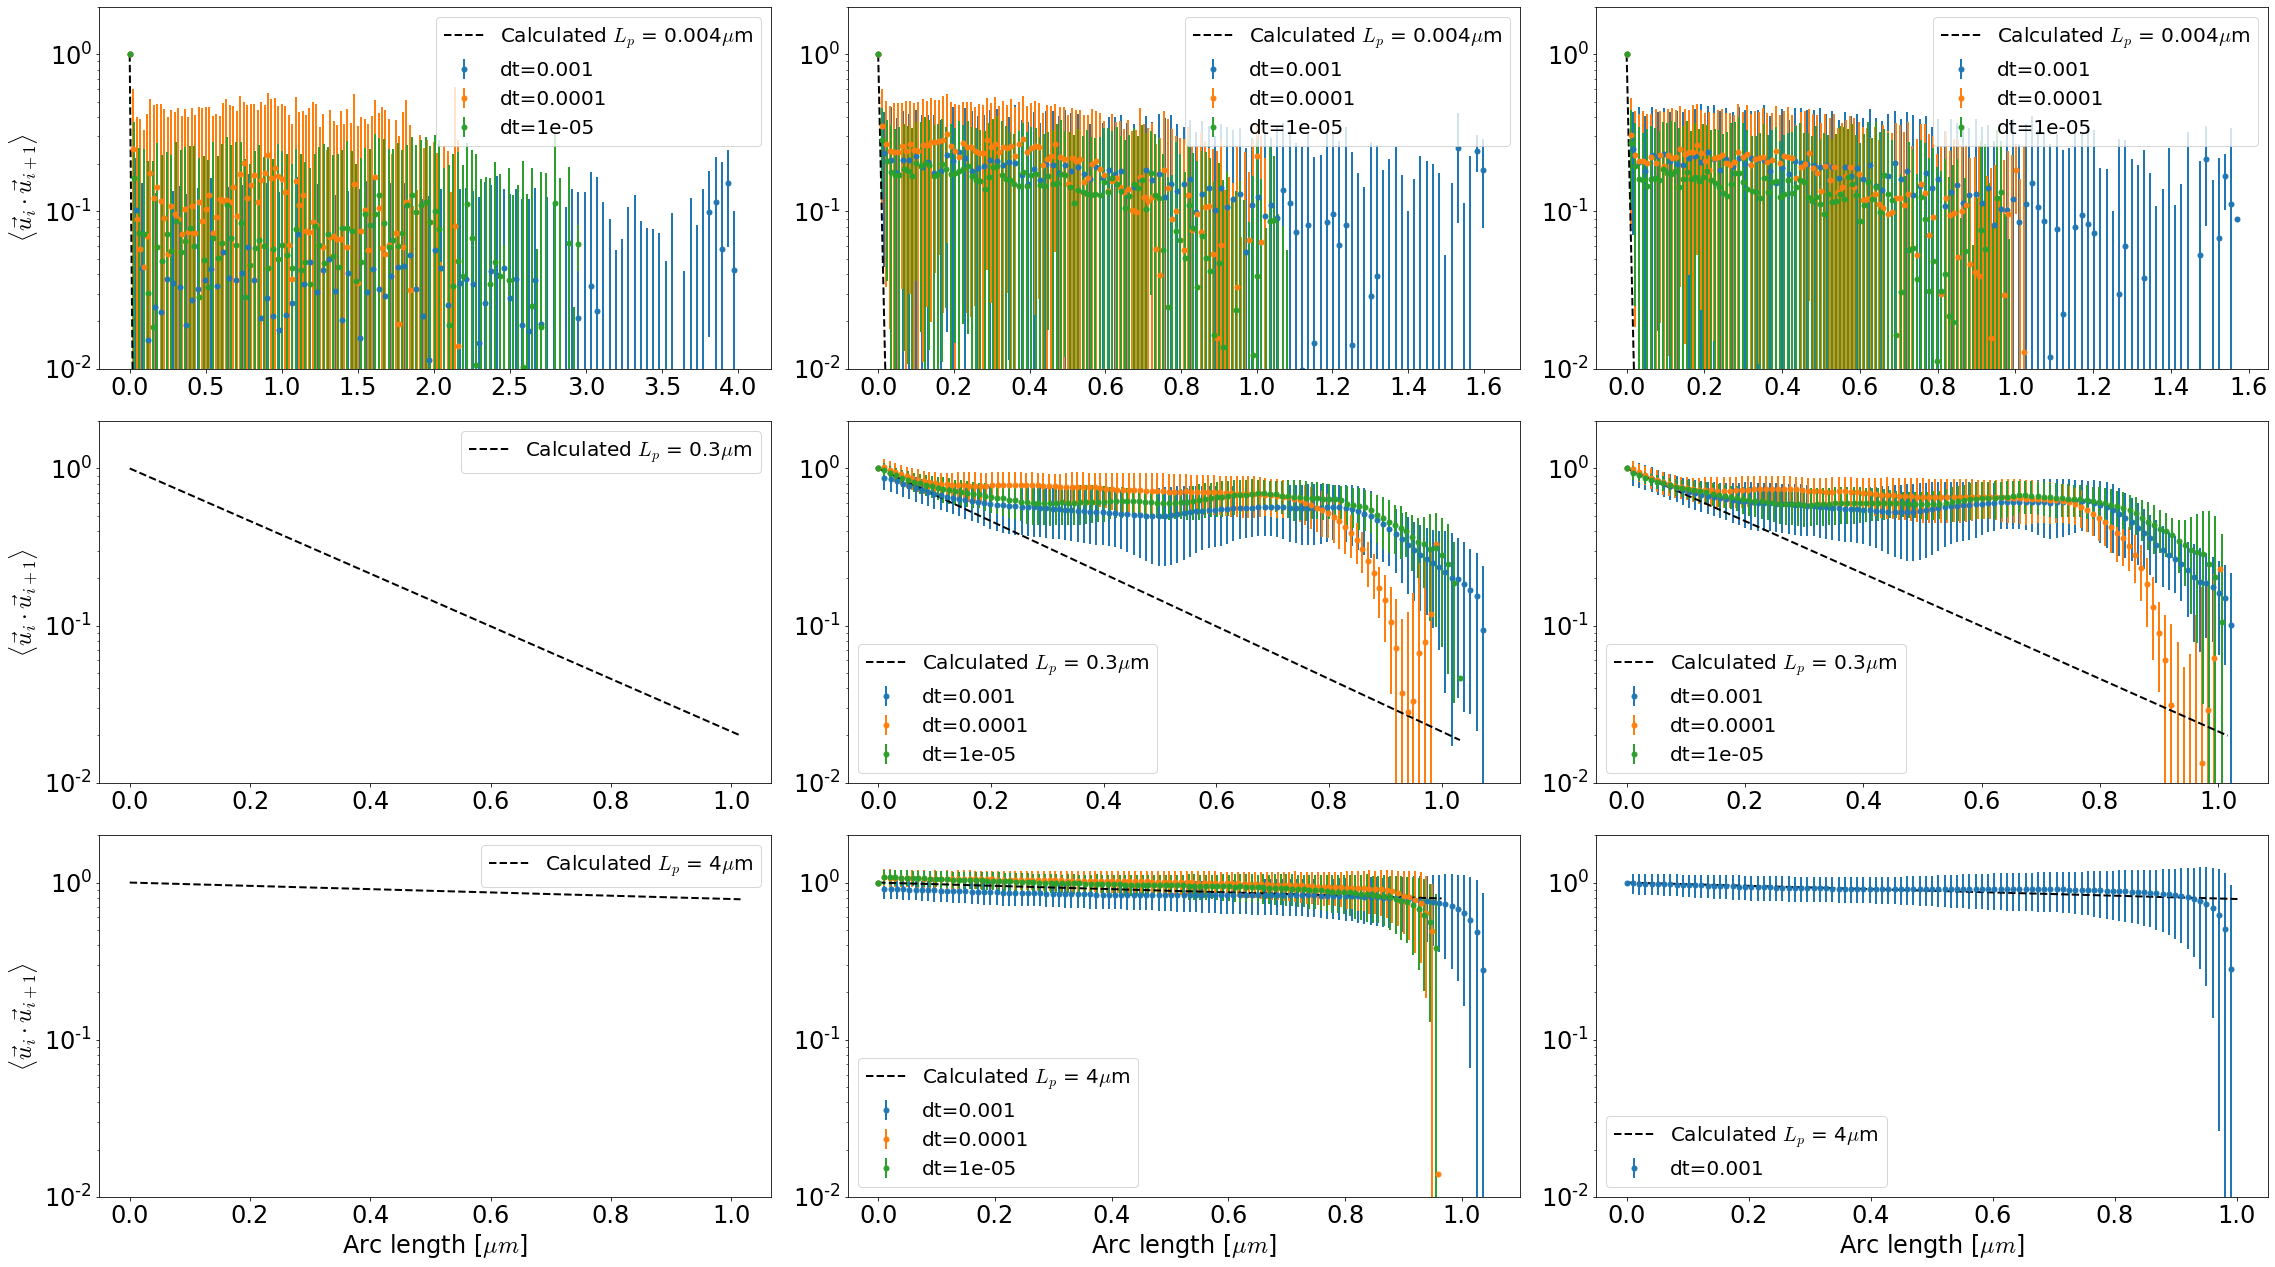

In [48]:
diam = .01
def fit_func(x, a, Lp):
    return a*np.exp(-x/Lp)
fig, axarr = plt.subplots(len(k_bend_list),len(k_extend_list), figsize=(32, 18))
theta_arr = np.linspace(0, np.pi, 1000)
for i, k_bend in enumerate(k_bend_list):
    for j, k_extend in enumerate(k_extend_list):
        Lp = k_bend*diam/kBT
        for k, dt in enumerate(dt_list):
            try: 
                with h5py.File(data_dict[k_bend][k_extend][dt], 'r') as h5_data:
                    run_params = yaml.safe_load(h5_data.attrs['RunConfig'])

                    time_arr = h5_data['time'][:] 
                    sy_dat = h5_data['raw_data/sylinders'][...]
                    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
                    print(com_arr.shape)
                    dir_arr = (com_arr[1:, :,100::100] - com_arr[:-1, :, 100::100])
                    length = np.linalg.norm(dir_arr[0,:,0])
                    dir_arr /= length

                    n_segs = dir_arr.shape[0]
                    dot_mat = np.einsum('ijk,ljk->ilk', dir_arr, dir_arr).mean(axis=2)
                    arc_length_arr = np.arange(n_segs)*length
                    avg_dot_arr = np.zeros(n_segs)
                    std_dot_arr = np.zeros(n_segs)
                    avg_dot_arr[0] = 1.
                    std_dot_arr[0] = 0. 
                    for n in range(1, n_segs):
                        avg_dot_arr[n] = np.diag(dot_mat, n).mean()
                        std_dot_arr[n] = np.diag(dot_mat, n).std()
                _ = axarr[i,j].errorbar(arc_length_arr[:], avg_dot_arr[:], yerr=std_dot_arr, marker='o', linestyle='none', markersize=5, label=f'dt={dt}')
            except:
                pass

        _ = axarr[i,j].plot(arc_length_arr, fit_func(arc_length_arr, 1, Lp), color='black',  linestyle='--', label=f'Calculated $L_p$ = {Lp:.1g}$\mu$m')
        _ = axarr[i,j].set_yscale('log')
        # _ = axarr[i,j].set_xlabel('Arc length [$\mu m$]')
        # _ = axarr[i,j].set_ylabel('$\langle \\vec{u}_i \\cdot \\vec{u}_{i+1} \\rangle$')
        _ = axarr[i,j].legend()
        _ = axarr[i,j].set_ylim(.01, 2)
for ax in axarr[-1,:]:
    _ = ax.set_xlabel('Arc length [$\mu m$]')

for ax in axarr[:,0]:
    _ = ax.set_ylabel('$\langle \\vec{u}_i \\cdot \\vec{u}_{i+1} \\rangle$')
fig.tight_layout()

The fact that the the higher spring stiffnesses show good matches with the theory makes me think that that the filaments have not equilibrated. Therefore, I should rerun the tests but with a longer runtime. I've now done the calculation for the relaxation time and it looks like I will need to go to about 10 seconds to capture most of the sims. Also, I want to test out if there is an instability so I will run the simulations with $\lambda < 2\kappa$ which is pretty easy. To speed things up, I will only use 50 beads in the next test.

In [7]:
test_dir = Path.home() / "ceph/DATA/Testing/SemiFlexBeadSpringFilament_50beads/"
h5_list = list(test_dir.glob('simulations/*/analysis/raw*.h5'))
data_dict = {}
for h5d in h5_list:
    with h5py.File(h5d, 'r') as h5_data:
        run_params = yaml.safe_load(h5_data.attrs['RunConfig'])
        kappa_extend = run_params['extendLinkKappa']
        kappa_bend = run_params['tribendLinkKappa']
        dt = run_params['dt']
        # See if dt value is already in data_dict. If not add it otherwise append to existing list
        if kappa_bend not in data_dict:
            data_dict[kappa_bend] = {}
        if kappa_extend not in data_dict[kappa_bend]:
            data_dict[kappa_bend][kappa_extend] = {}
        data_dict[kappa_bend][kappa_extend][dt]= h5d

k_bend_list = sorted(data_dict.keys())
print("k_bend: ", k_bend_list)
k_extend_list = sorted(data_dict[k_bend_list[0]].keys())
print("k_extend: ", k_extend_list)
dt_list = sorted(data_dict[k_bend_list[0]][k_extend_list[-1]].keys(), reverse=True)
print("dt: ", dt_list)


k_bend:  [0.00166572026, 0.0166572026, 0.106606097, 1.70569755]
k_extend:  [10.275, 102.75, 1027.5, 102750.0]
dt:  [0.001, 0.0001, 1e-05, 5e-06]


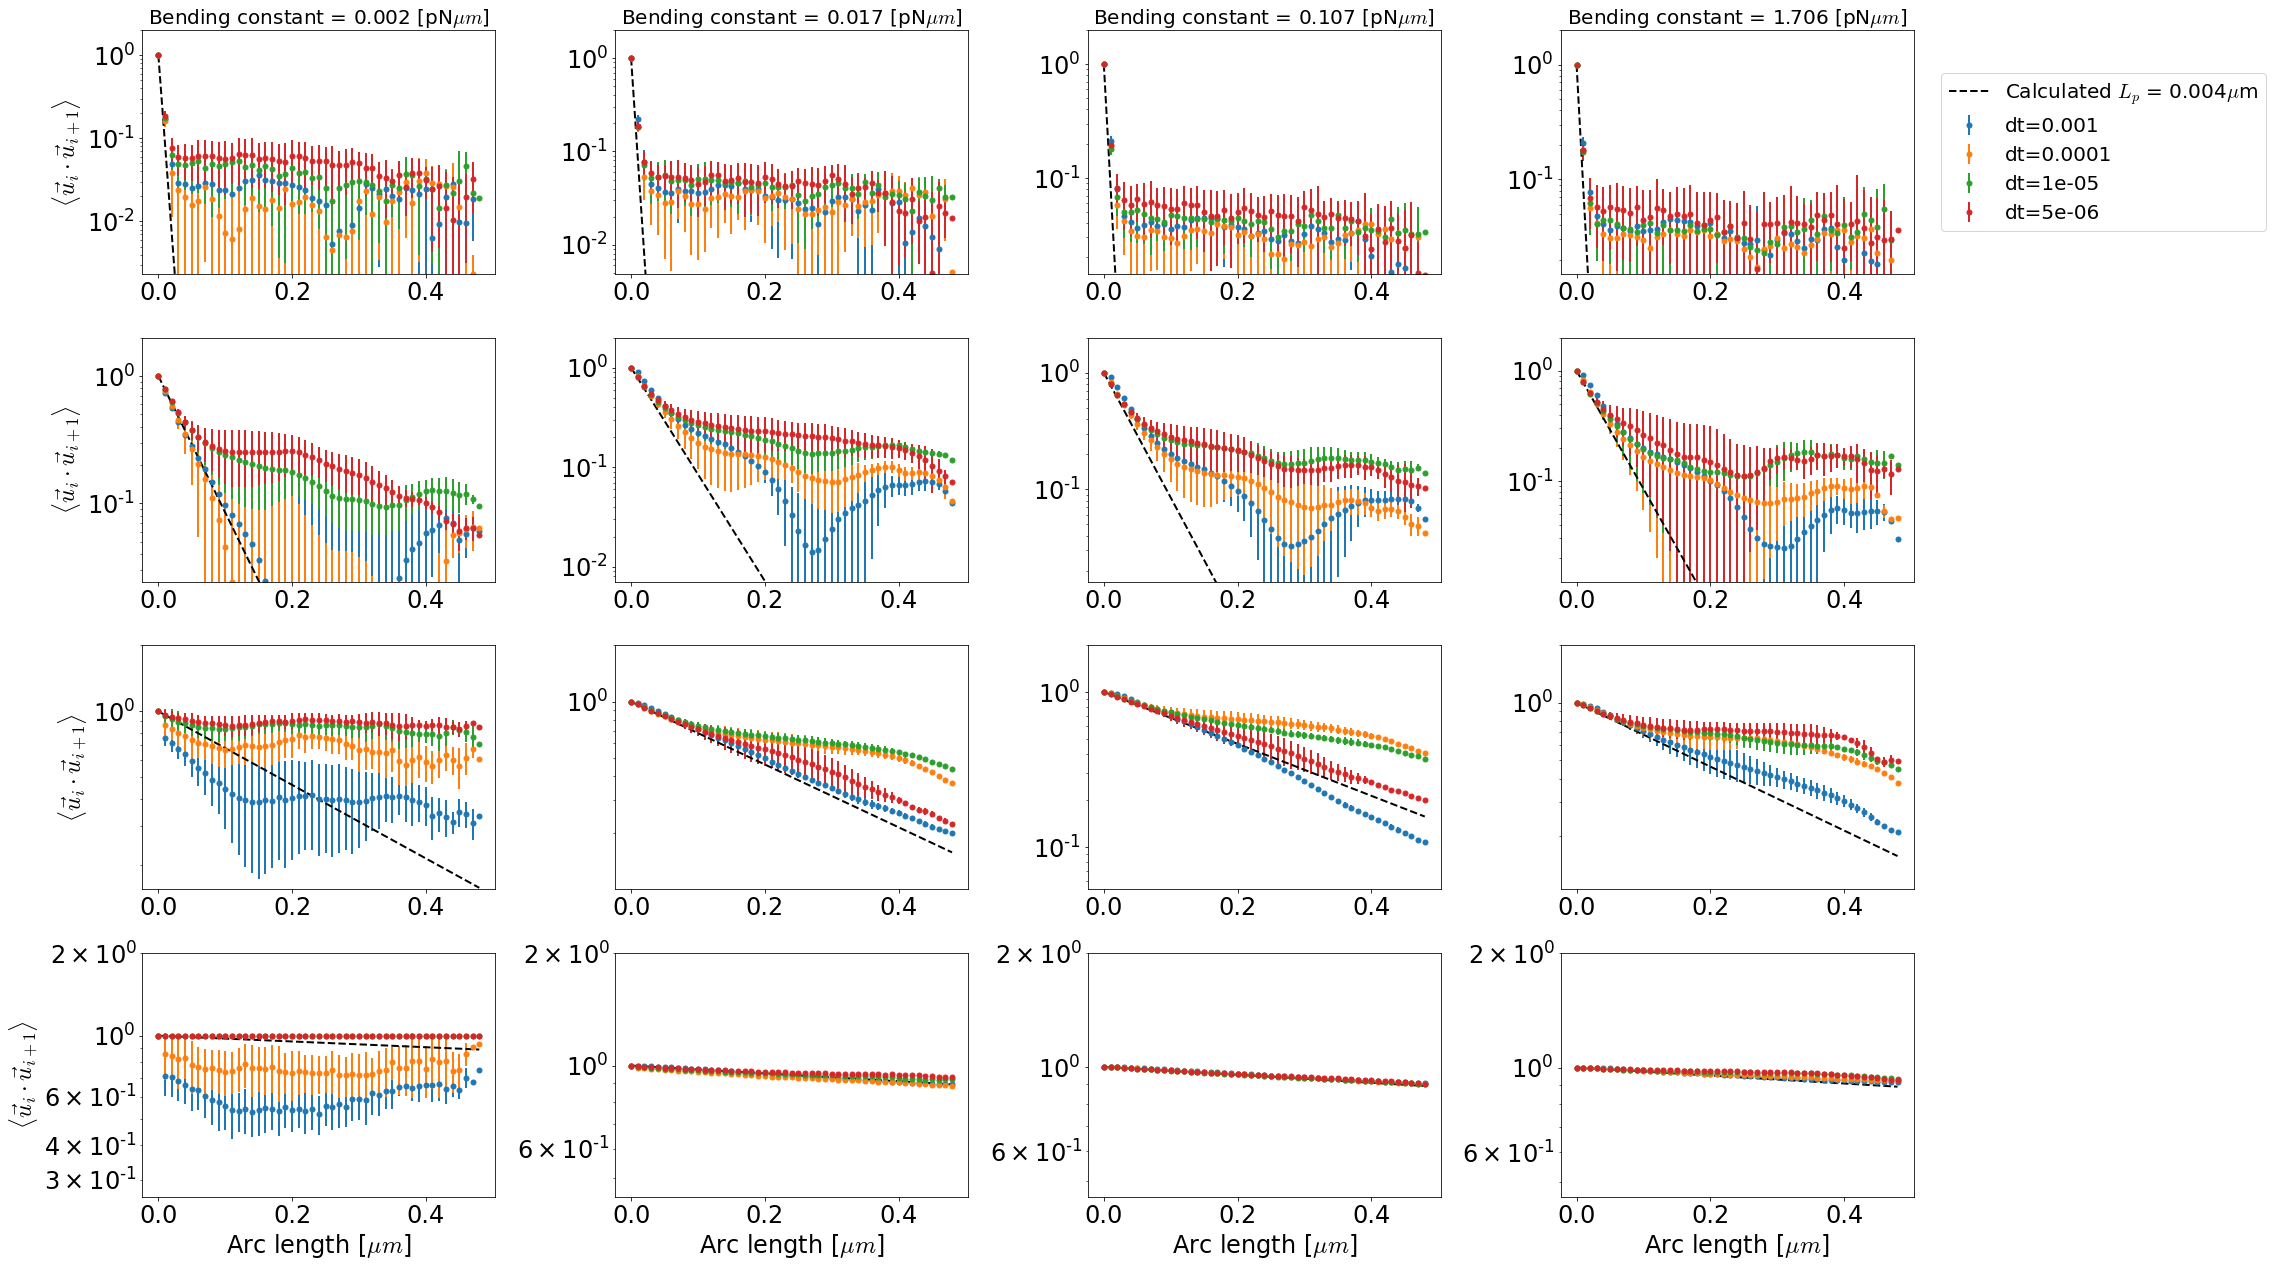

In [42]:
diam = .01
def fit_func(x, a, Lp):
    return a*np.exp(-x/Lp)
fig, axarr = plt.subplots(len(k_bend_list),len(k_extend_list), figsize=(32, 18))
theta_arr = np.linspace(0, np.pi, 1000)
for i, k_bend in enumerate(k_bend_list):
    for j, k_extend in enumerate(k_extend_list):
        Lp = k_bend*diam/kBT
        for k, dt in enumerate(dt_list):
            try: 
                with h5py.File(data_dict[k_bend][k_extend][dt], 'r') as h5_data:
                    run_params = yaml.safe_load(h5_data.attrs['RunConfig'])

                    time_arr = h5_data['time'][:] 
                    sy_dat = h5_data['raw_data/sylinders'][...]
                    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
                    dir_arr = (com_arr[1:, :,:] - com_arr[:-1, :, :])
                    # print(dir_arr)
                    length = np.linalg.norm(dir_arr[:,:,:], axis=1, keepdims=True)
                    dir_arr = np.where(length > 0, dir_arr / length, dir_arr)
                    # print(dir_arr)
                    # print(dir_arr.shape)

                    n_segs = dir_arr.shape[0]
                    dot_mat = np.einsum('ijk,ljk->ilk', dir_arr, dir_arr).mean(axis=2)
                    # arc_length_arr = np.arange(n_segs)*length
                    arc_length_arr = np.arange(n_segs)*diam
                    avg_dot_arr = np.zeros(n_segs)
                    std_dot_arr = np.zeros(n_segs)
                    avg_dot_arr[0] = 1.
                    std_dot_arr[0] = 0. 
                    for n in range(1, n_segs):
                        avg_dot_arr[n] = np.diag(dot_mat, n).mean()
                        std_dot_arr[n] = np.diag(dot_mat, n).std()
                _ = axarr[i,j].errorbar(arc_length_arr, avg_dot_arr[:], yerr=std_dot_arr, marker='o', linestyle='none', markersize=5, label=f'dt={dt}')
            except:
                pass

            if dt == 0.001:
                _ = axarr[i,j].set_ylim(np.abs(np.amin(avg_dot_arr))*.5, 2)

        _ = axarr[i,j].plot(arc_length_arr, fit_func(arc_length_arr, 1, Lp), color='black',  linestyle='--', label=f'Calculated $L_p$ = {Lp:.1g}$\mu$m')
        _ = axarr[i,j].set_yscale('log')
        # _ = axarr[i,j].set_xlabel('Arc length [$\mu m$]')
        # _ = axarr[i,j].set_ylabel('$\langle \\vec{u}_i \\cdot \\vec{u}_{i+1} \\rangle$')
        # _ = axarr[i,j].legend()

for ax, k_bend in zip(axarr[0,:], k_bend_list):
    _ = ax.set_title(f'Bending constant = {k_bend:.3f} [pN$\mu m$]')

for ax in axarr[-1,:]:
    _ = ax.set_xlabel('Arc length [$\mu m$]')

for ax in axarr[:,0]:
    _ = ax.set_ylabel('$\langle \\vec{u}_i \\cdot \\vec{u}_{i+1} \\rangle$')

_ = axarr[0,-1].legend(loc='center left', bbox_to_anchor=(1.05, .5))

fig.tight_layout()